In [2]:
import seaborn as sns
import matplotlib.pyplot as plt
import os
import torch
import numpy as np
import pandas as pd

from notebook_utils import *

In [3]:
all_metrics = {}

In [4]:
strategies_names = ["aleatoric_propagated", "educated_random", "augment_latent", "age","anrmab", "entropy","tta_expected_query_score", "random"]
metrics_dict_cora_gcn = load_results("cora_ml", "gcn", strategies_names, save=True, cached=False, cache_path="../other_data")
all_metrics[("cora_ml", "gcn")] = metrics_dict_cora_gcn

Loading metrics cora_ml gcn
	aleatoric_propagated metrics
	educated_random metrics
	augment_latent metrics
	age metrics
	anrmab metrics
	entropy metrics
	tta_expected_query_score metrics
	random metrics
Saving metrics to cache


In [5]:
strategies_names = ["aleatoric_propagated", "age","anrmab", "entropy", "random"]
metrics_dict_cora_sgc = load_results("cora_ml", "sgc", strategies_names, save=False, cached=False, cache_path="../other_data")
all_metrics[("cora_ml", "sgc")] = metrics_dict_cora_sgc

Loading metrics cora_ml sgc
	aleatoric_propagated metrics
	age metrics
	anrmab metrics
	entropy metrics
	random metrics


In [11]:
for dataset in ["citeseer", "pubmed", "amazon_photos"]:
    for model in ["gcn", "sgc"]:
        strategies_names = ["aleatoric_propagated", "age","anrmab", "entropy"]
        metrics_dict = load_results(dataset, model, strategies_names, save=False, cached=False, cache_path="../other_data")
        all_metrics[(dataset, model)] = metrics_dict

Loading metrics citeseer gcn
	aleatoric_propagated metrics
	age metrics
	anrmab metrics
	entropy metrics
Loading metrics citeseer sgc
	aleatoric_propagated metrics
	age metrics
	anrmab metrics
	entropy metrics
Loading metrics pubmed gcn
	aleatoric_propagated metrics
	age metrics
	anrmab metrics
	entropy metrics
Loading metrics pubmed sgc
	aleatoric_propagated metrics
	age metrics
	anrmab metrics
	entropy metrics
Loading metrics amazon_photos gcn
	aleatoric_propagated metrics
	age metrics
	anrmab metrics
	entropy metrics
Loading metrics amazon_photos sgc
	aleatoric_propagated metrics
	age metrics
	anrmab metrics
	entropy metrics


In [6]:
runs = combine_geem_metrics("cora_ml")
agg, stds = aggregate_geem_metrics("cora_ml")
# all_metrics[("cora_ml", "gcn")]["geem"] = (agg["accuracy/test"], stds["accuracy/test"], agg, runs)
all_metrics[("cora_ml", "sgc")]["geem"] = (agg["accuracy/test"], stds["accuracy/test"], agg, runs)


In [7]:
df_combineds = {}
for (dataset,model), metrics_dict in all_metrics.items():
    df_combined, df = create_df(metrics_dict)
    df_combineds[(dataset,model)] = (df_combined,df)

In [8]:
df_combined, df = df_combineds[("cora_ml", "gcn")]


In [9]:
df_combined = []
for d_m_key in [("cora_ml", "sgc"), ("cora_ml", "gcn")]:    
    # d_m_key = ("cora_ml", "sgc")
    big_cora_df = df_combineds[d_m_key][0]
    l = [get_count_dict(all_metrics[d_m_key][x][3]) for x in big_cora_df.index]
    big_cora_df["num_acquired_indices"] = [len(i[0]) for i in l]
    big_cora_df["num_acquired_indices"] /= 700
    big_cora_df["max_acquired"] = [i[1].max().item() for i in l]
    big_cora_df["max_acquired_index"] = [i[1].argmax().item() for i in l]
    big_cora_df["strategy"] = [i.split("_")[0] for i in big_cora_df.index]
    big_cora_df["tta"] = [True if ("probs" in i) or ("logits" in i)  else False for i in big_cora_df.index]
    big_cora_df["filter"] = [True if "filter" in i else False for i in big_cora_df.index]
    big_cora_df.loc[(big_cora_df["tta"] == True), "strategy"] = big_cora_df.loc[(big_cora_df["tta"] == True), "strategy"] + "_tta"
    big_cora_df.loc[(big_cora_df["filter"] == True), "strategy"] = big_cora_df.loc[(big_cora_df["filter"] == True), "strategy"] + "_filter"

    big_cora_df.loc[(big_cora_df.index.str.contains("iquery")), "strategy"] = big_cora_df.loc[(big_cora_df.index.str.contains("iquery")), "strategy"] + "_adapted"
    big_cora_df.replace({"strategy": {"aleatoric_tta": "aleatoric_qes","aleatoric_tta_filter":"aleatoric_qes_filter", "tta": "aleatoric_eqs","tta_filter": "aleatoric_eqs_filter", "augment": "aleatoric_qes","augment_filter": "aleatoric_qes_filter"}}, inplace=True)
    big_cora_df["strategy"] = big_cora_df["strategy"] + "_" + d_m_key[1]
    big_cora_df["dataset"] = d_m_key[0]
    big_cora_df["model"] = d_m_key[1]
    big_cora_df.index = big_cora_df.index + "_" + d_m_key[1]
    df_combined.append(big_cora_df)
    

In [10]:
big_cora_df = pd.concat(df_combined)
big_cora_df

,0_mean,5_mean,10_mean,15_mean,20_mean,28_mean,0_std,5_std,10_std,15_std,...,28_mean_formatted,nalc,num_acquired_indices,max_acquired,max_acquired_index,strategy,tta,filter,dataset,model
geem_sgc,39.714286,60.164286,74.664286,78.578572,80.128571,82.171429,8.177869,10.266465,5.058162,3.523058,...,82.2 ± 1.2,100.000000,0.231429,19,89,geem_sgc,False,False,cora_ml,sgc
aleatoric_propagated_fnoise_emask_100_filter_probs_0.5_0.1_sgc,43.121428,61.800000,71.021428,73.907142,76.471429,79.078572,10.769870,5.705332,4.532063,4.241835,...,79.1 ± 1.7,95.563263,0.364286,16,732,aleatoric_qes_filter_sgc,True,True,cora_ml,sgc
aleatoric_propagated_fnoise_emask_100_filter_probs_0.4_0.4_sgc,43.121428,60.950000,69.014286,73.185715,75.471429,79.000000,10.769870,7.810531,5.550125,3.383513,...,79.0 ± 2.3,94.514657,0.411429,15,2063,aleatoric_qes_filter_sgc,True,True,cora_ml,sgc
aleatoric_propagated_fnoise_emask_100_filter_probs_0.1_0.4_sgc,43.121428,59.300000,66.642857,72.028571,75.342858,78.964286,10.769870,7.273961,7.184166,5.553975,...,79.0 ± 3.5,93.124257,0.480000,17,2203,aleatoric_qes_filter_sgc,True,True,cora_ml,sgc
aleatoric_propagated_fnoise_emask_100_filter_probs_0.3_0.5_sgc,43.121428,61.414286,70.650000,74.885714,76.857143,78.864286,10.769870,8.209303,4.636501,3.338428,...,78.9 ± 2.4,96.031245,0.437143,16,2063,aleatoric_qes_filter_sgc,True,True,cora_ml,sgc
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
aleatoric_propagated_adj_lr0.1_epochs50_iquery_gcn,44.521429,56.049999,60.128571,63.364285,62.028571,69.857144,11.630989,8.527016,7.484767,7.318150,...,69.9 ± 3.8,86.170414,0.268571,23,2290,aleatoric_adapted_gcn,False,False,cora_ml,gcn
aleatoric_propagated_graph_lra0.01_lrf0.01_epochs20_iquery_gcn,44.978571,58.614285,66.392858,66.585714,68.250000,69.814286,9.781062,9.581189,4.746105,2.397022,...,69.8 ± 4.2,92.155348,0.240000,20,586,aleatoric_adapted_gcn,False,False,cora_ml,gcn
aleatoric_propagated_adj_lr0.01_epochs10_iquery_gcn,45.900000,51.414285,60.807142,63.535713,67.721429,69.678572,10.576915,10.705106,7.480777,7.440237,...,69.7 ± 3.2,87.819023,0.222857,25,2203,aleatoric_adapted_gcn,False,False,cora_ml,gcn
aleatoric_propagated_graph_lra0.05_lrf0.01_epochs10_iquery_gcn,44.185714,60.135714,67.078571,69.249999,67.771430,69.314286,10.011483,6.890410,4.754664,2.109864,...,69.3 ± 2.9,92.230921,0.260000,22,586,aleatoric_adapted_gcn,False,False,cora_ml,gcn


In [13]:
big_cora_df[big_cora_df.index.str.contains("random")]

,0_mean,5_mean,10_mean,15_mean,20_mean,28_mean,0_std,5_std,10_std,15_std,...,28_mean_formatted,nalc,num_acquired_indices,max_acquired,max_acquired_index,strategy,tta,filter,dataset,model
random_None_sgc,40.071429,53.057143,61.321429,66.150000,69.292858,74.457143,6.987781,7.936502,5.960114,4.935317,...,74.5 ± 2.7,86.016652,0.858571,5,828,random_sgc,False,False,cora_ml,sgc
educated_random_aleatoric_propagated_60_0_gcn,42.650000,57.407143,66.428572,72.185714,74.785714,78.292856,12.299585,9.596066,6.125391,5.325689,...,78.3 ± 2.5,98.189159,0.818571,3,906,educated_gcn,False,False,cora_ml,gcn
educated_random_aleatoric_propagated_60_1_gcn,41.750000,55.014286,64.792857,71.214286,73.992857,78.185714,11.395152,11.037496,9.113049,6.312645,...,78.2 ± 3.0,96.151603,0.818571,3,402,educated_gcn,False,False,cora_ml,gcn
educated_random_aleatoric_propagated_70_0_gcn,43.728571,57.335715,67.757143,72.692857,74.771429,77.835714,13.668574,8.065092,7.691282,3.984959,...,77.8 ± 2.8,98.940767,0.805714,4,541,educated_gcn,False,False,cora_ml,gcn
educated_random_aleatoric_propagated_fmask_emask_100_filter_probs_0.5_0.4_80.0_1_gcn,43.614286,56.942857,65.378571,71.521428,74.449999,77.828572,11.864808,11.765060,7.252255,5.058111,...,77.8 ± 2.4,97.291747,0.791429,4,643,educated_tta_filter_gcn,True,True,cora_ml,gcn
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
random_None_gcn,40.535714,52.464286,60.735714,64.464285,68.242858,72.821429,11.274520,11.252324,10.026791,9.674419,...,72.8 ± 6.0,89.915721,0.854286,4,334,random_gcn,False,False,cora_ml,gcn
educated_random_aleatoric_propagated_10_5_gcn,41.285714,53.442857,59.771429,66.814285,68.678571,72.735715,12.266700,12.222169,10.599688,7.619738,...,72.7 ± 8.2,90.719901,0.848571,3,79,educated_gcn,False,False,cora_ml,gcn
educated_random_aleatoric_propagated_10_0_gcn,40.707143,55.550000,62.092858,67.628571,69.221428,72.428571,11.238654,8.213186,8.964574,6.474148,...,72.4 ± 5.3,91.430437,0.834286,3,493,educated_gcn,False,False,cora_ml,gcn
educated_random_aleatoric_propagated_fmask_emask_100_filter_probs_0.5_0.4_0.0_10_gcn,40.985714,55.950000,59.900000,66.271429,69.850001,72.000000,10.625479,10.778583,8.417075,5.636597,...,72.0 ± 5.5,90.027025,0.875714,3,228,educated_tta_filter_gcn,True,True,cora_ml,gcn


<Axes: ylabel='Frequency'>

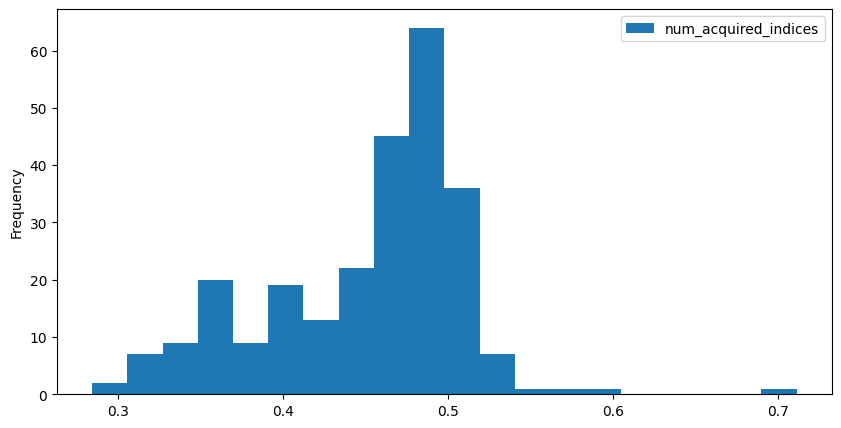

In [11]:
big_cora_df[big_cora_df["strategy"].str.contains("aleatoric_qes_filter") ].sort_values("num_acquired_indices", ascending=False)[["num_acquired_indices"]].plot(kind="hist", figsize=(10, 5), bins=20)

In [14]:
scatter.legend_elements()

([<matplotlib.lines.Line2D at 0x73ce91d15f50>,
 ['$\\mathdefault{0.0}$',
  '$\\mathdefault{2.5}$',
  '$\\mathdefault{5.0}$',
  '$\\mathdefault{7.5}$',
  '$\\mathdefault{10.0}$',
  '$\\mathdefault{12.5}$',
  '$\\mathdefault{15.0}$',
  '$\\mathdefault{17.5}$',
  '$\\mathdefault{20.0}$'])

In [15]:
unique_categories

Index(['age_gcn', 'age_sgc', 'age_tta_filter_gcn', 'age_tta_filter_sgc',
       'aleatoric_eqs_filter_gcn', 'aleatoric_gcn', 'aleatoric_qes_filter_gcn',
       'aleatoric_qes_filter_sgc', 'aleatoric_qes_gcn', 'aleatoric_sgc',
       'anrmab_gcn', 'anrmab_sgc', 'anrmab_tta_filter_gcn',
       'anrmab_tta_filter_sgc', 'entropy_gcn', 'entropy_sgc',
       'entropy_tta_filter_gcn', 'entropy_tta_filter_sgc', 'geem_sgc',
       'random_gcn', 'random_sgc'],
      dtype='object')

In [19]:
category_mapping

{0: 'age_sgc',
 1: 'age_tta_filter_sgc',
 2: 'aleatoric_qes_filter_sgc',
 3: 'aleatoric_sgc',
 4: 'anrmab_sgc',
 5: 'anrmab_tta_filter_sgc',
 6: 'entropy_sgc',
 7: 'entropy_tta_filter_sgc',
 8: 'geem_sgc',
 9: 'random_sgc'}

In [23]:
inverted_category_mapping = {v: k for k, v in category_mapping.items()}
inverted_category_mapping


{'age_sgc': 0,
 'age_tta_filter_sgc': 1,
 'aleatoric_qes_filter_sgc': 2,
 'aleatoric_sgc': 3,
 'anrmab_sgc': 4,
 'anrmab_tta_filter_sgc': 5,
 'entropy_sgc': 6,
 'entropy_tta_filter_sgc': 7,
 'geem_sgc': 8,
 'random_sgc': 9}

In [28]:
inverted_category_mapping

{'age_sgc': 0,
 'age_tta_filter_sgc': 1,
 'aleatoric_qes_filter_sgc': 2,
 'aleatoric_sgc': 3,
 'anrmab_sgc': 4,
 'anrmab_tta_filter_sgc': 5,
 'entropy_sgc': 6,
 'entropy_tta_filter_sgc': 7,
 'geem_sgc': 8,
 'random_sgc': 9}

In [46]:
handles

AttributeError: module 'seaborn' has no attribute 'scatter'

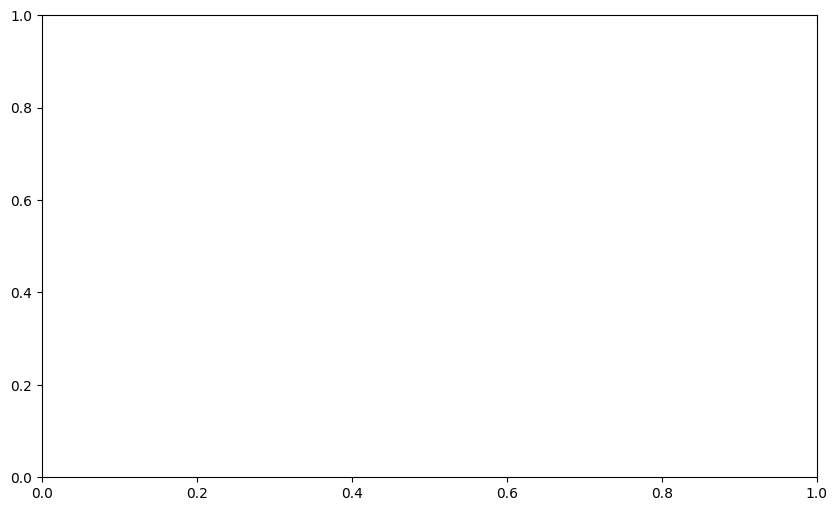

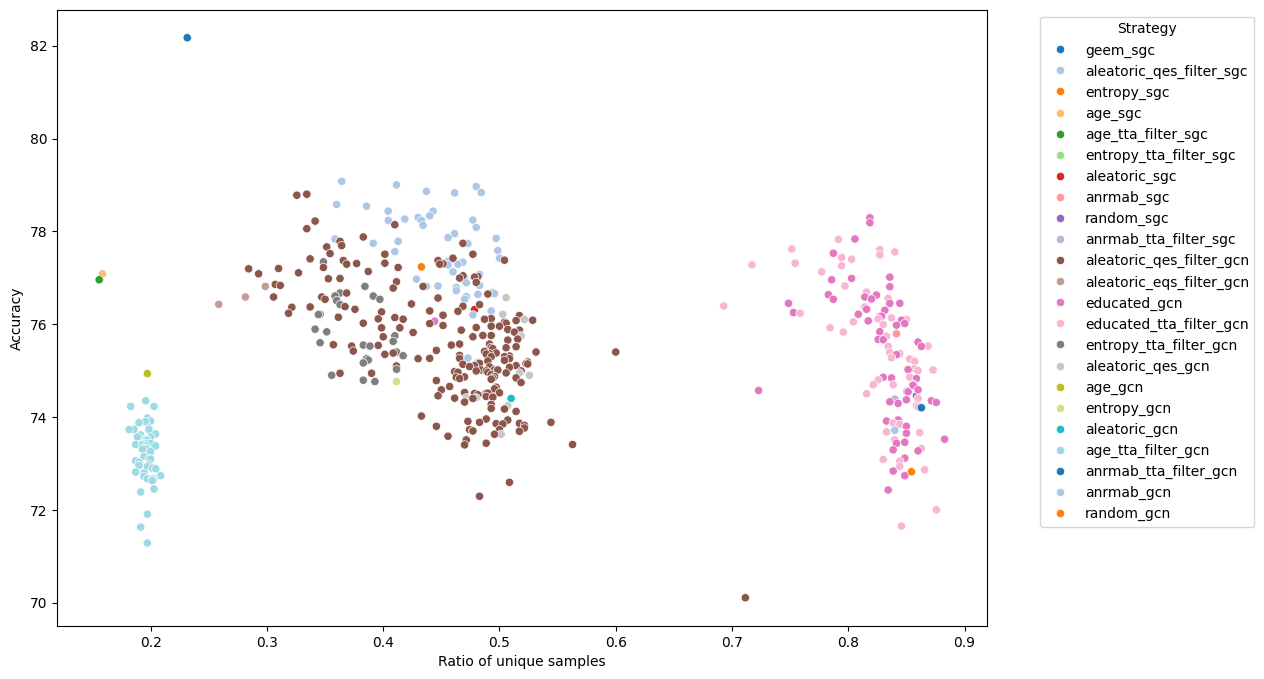

In [60]:
to_plot = big_cora_df[ ~big_cora_df.index.str.contains("iquery")]
plt.figure(figsize=(12, 8))
sns.scatterplot(data=to_plot, x="num_acquired_indices", y="28_mean", hue="strategy", palette="tab20")
plt.xlabel("Ratio of unique samples")
plt.ylabel("Accuracy")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', title="Strategy")
plt.show()

In [ ]:
big_cora_df["num_acquired_indices"].plot(kind="hist", bins=100)

In [ ]:
# d = []
# for k,v in metrics_dict_cora_gcn.items():
#     cd, c, i = get_count_dict(v[3])
#     d.append([k,len(cd), c.max().item(), c.argmax().item()])

# count_dict_df = pd.DataFrame(d, columns=["key", "num_acquired_indices", "max_acquisitions", "max_acquisition_index"])
# count_dict_df.sort_values(by="num_acquired_indices", ascending=True, inplace=True)
# count_dict_df

In [ ]:
count_dict, count, ixs =  get_count_dict(metrics_dict_cora_gcn[key1][3])

plt.hist(list(count_dict.values()), bins=100)
plt.show()

In [ ]:
key1 = "aleatoric_propagated_None"
key2 = "geem"
d_m_key = ("cora_ml", "sgc")

count_dict_1, count_1, ixs_1 = get_count_dict(all_metrics[d_m_key][key1][3])
# count_dict_1, count_1, ixs_1 = get_count_dict(runs)
print(f"Maximally acquired index: {count_1.argmax()} with {count_1.max()} acquisitions")

count_dict_2, count_2, ixs_2 = get_count_dict(all_metrics[d_m_key][key2][3])
print(f"Maximally acquired index: {count_2.argmax()} with {count_2.max()} acquisitions")
print("------")

print(f"Intersection of acquired indices: {len(set(count_dict_1.keys()).intersection(set(count_dict_2.keys())))}")
print(f"Union of acquired indices: {len(set(count_dict_1.keys()).union(set(count_dict_2.keys())))}")
print(f"{key1} acquired indices: {len(count_dict_1)}")
print(f"{key2} acquired indices: {len(count_dict_2)}")